In [206]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import glob
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow.contrib.slim as slim
from sklearn.model_selection import train_test_split
from collections import Counter
%matplotlib inline

In [207]:
tf.__version__

'1.14.0'

In [98]:
IMG_SIZE = (150, 150)
COLOR_CHANNELS = 3

In [99]:
parasitized_path = '/home/anisie/Projects/malaria_cell_classification_code/cell_images/Parasitized'
uninfected_path = '/home/anisie/Projects/malaria_cell_classification_code/cell_images/Uninfected'

In [100]:
parasitized_names = glob.glob(parasitized_path+"/*.png")
uninfected_names = glob.glob(uninfected_path+"/*.png")

In [101]:
np.random.seed(42)
data = pd.DataFrame({
    'filename': uninfected_names + parasitized_names,
    'label': ['malaria'] * len(parasitized_names) + ['healthy'] * len(uninfected_names)
}).sample(frac=1, random_state=42).reset_index(drop=True)

data.head()

,filename,label
0,/home/anisie/Projects/malaria_cell_classificat...,malaria
1,/home/anisie/Projects/malaria_cell_classificat...,malaria
2,/home/anisie/Projects/malaria_cell_classificat...,healthy
3,/home/anisie/Projects/malaria_cell_classificat...,healthy
4,/home/anisie/Projects/malaria_cell_classificat...,healthy


In [102]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(data['filename'].values,
                                                                      data['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17361,) (1929,) (8268,)
Train: Counter({'healthy': 8734, 'malaria': 8627}) 
Val: Counter({'healthy': 970, 'malaria': 959}) 
Test: Counter({'malaria': 4193, 'healthy': 4075})


<BarContainer object of 2 artists>

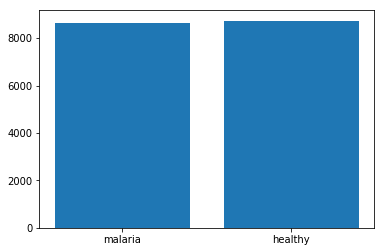

In [125]:
import matplotlib.pyplot as plt

ct = Counter(train_labels)
plt.bar(ct.keys(), ct.values())

In [104]:
# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:10], train_labels_enc[:10])

['malaria' 'malaria' 'malaria' 'healthy' 'healthy' 'malaria' 'healthy'
 'malaria' 'healthy' 'healthy'] [1 1 1 0 0 1 0 1 0 0]


In [136]:
#load  training, testing and validation data
train_data,var_data,test_data= [],[],[]

# Training set
for i in train_files:
    td = cv.resize(cv.imread(i), IMG_SIZE)/255
    train_data.append(td)
    #  varidation set
    
for i in val_files:
    vd = cv.resize(cv.imread(i), IMG_SIZE)/255
    var_data.append(vd)
    
    # Testing set
for i in test_files:
    tsd = cv.resize(cv.imread(i), IMG_SIZE)/255
    test_data.append(tsd)


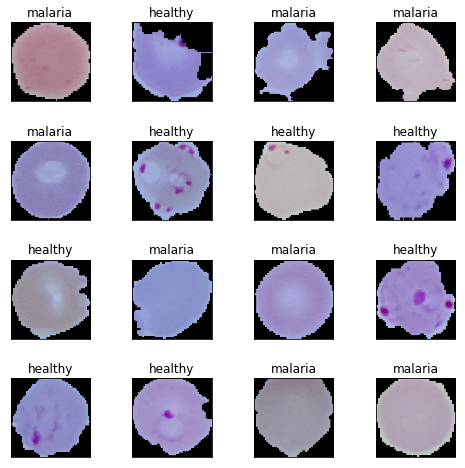

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , len(train_data) , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]])
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [139]:
import tensorflow as tf

# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

tf.set_random_seed(42)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [141]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (150, 150, 3) #(125, 125, 3)

In [142]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 128)       0   

In [143]:
# Clear any logs from previous runs
!rm -rf ./logs/ 
%tensorboard 

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
/home/anisie/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/anisie/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/anisie/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)

In [156]:
train_data[0].reshape(1, 150, 150, 3).shape

(1, 150, 150, 3)

In [196]:
new_train_x = np.array([x for x in train_data[:10]])
new_train_y = np.array([x for x in train_labels_enc[:10]])

In [199]:
new_train_y.shape

(10,)

In [200]:
new_train_x.shape

(10, 150, 150, 3)

In [195]:
tf.__version__

'1.14.0'

In [201]:
model.fit(x=new_train_x, y=new_train_y, 
                    batch_size=2,
                    epochs=2, 
                    validation_data=(var_data, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

ValueError: Error when checking input: expected input_2 to have 4 dimensions, but got array with shape (150, 150, 3)

In [144]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_data, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(var_data, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)
                    

ValueError: Error when checking input: expected input_2 to have 4 dimensions, but got array with shape (150, 150, 3)

In [146]:
train_data[0].shape

(150, 150, 3)

In [148]:
?model.fit

Signature:
model.fit(
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose=1,
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    **kwargs,
)
Docstring:
Trains the model for a fixed number of epochs (iterations on a dataset).

Arguments:
    x: Input data. It could be:
      - A Numpy array (or array-like), or a list of arrays
        (in case the model has multiple inputs).
      - A TensorFlow tensor, or a list of tensors
        (in case the model has multiple inputs).
      - A dict mapping input names to the corresponding array/tensors,
        if the model has named inputs.
      - A `tf.data` dataset or a dataset iterator. Should return a tuple
        of either `(inputs, targets)` or
        `(inputs, targets,